In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch

In [2]:
import h5py
Lab1_MNIST = h5py.File('MNISTdata.hdf5','r')
data_in=np.array(Lab1_MNIST['input'])
data_out=np.array(Lab1_MNIST['output'])
print(data_in.shape)
print(data_out.shape)

(2000, 28, 28, 1)
(2000, 1)


In [3]:
train_X,test_X, train_y, test_y = train_test_split(data_in,data_out,test_size=0.3,random_state=21)
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(1400, 28, 28, 1)
(600, 28, 28, 1)
(1400, 1)
(600, 1)


In [4]:
X_train=train_X.reshape(-1,784)
X_test=test_X.reshape(-1,784)
y_train=train_y.reshape(1400)
y_test=test_y.reshape(600)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1400, 784)
(600, 784)
(1400,)
(600,)


In [5]:
X_train=torch.FloatTensor(X_train)
X_test=torch.FloatTensor(X_test)
y_train=torch.LongTensor(y_train)
y_test=torch.LongTensor(y_test)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([1400, 784])
torch.Size([600, 784])
torch.Size([1400])
torch.Size([600])


In [6]:
train_data= list(zip(X_train,y_train))
test_data = list(zip(X_test,y_test))

In [7]:
trainloader = DataLoader(train_data, batch_size=64, shuffle=True)
testloader = DataLoader(test_data,batch_size=64, shuffle=False)
for images, labels in trainloader:
    print('Batch shape:', images.size())
    break

Batch shape: torch.Size([64, 784])


In [8]:
# Added one more layer to the model and changed number of units to 400 and 200 respectively
class Model_1(nn.Module):
    def __init__(self,in_features=784,h1 = 400,h2=200, out_features=10):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)
        self.fc2 = nn.Linear(h1,h2)          
        self.out = nn.Linear(h2,out_features)
    def forward(self,x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.out(x)
        
        return F.log_softmax(x,dim=1)
torch.manual_seed(4)
model_1 = Model_1()
model_1

Model_1(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=10, bias=True)
)

In [9]:
for item in model_1.parameters():
    print(item.numel())

313600
400
80000
200
2000
10


In [10]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(),lr=1e-4,weight_decay=1e-5)

In [11]:
# Training the model with 100 epochs
import time
start_time = time.time()
epoch=50
trn_loss1=[]
tst_loss1=[]
tst_corr = []
trn_corr = []
for i in range(epoch):
    num_tst_corr = 0
    num_trn_corr = 0
    for b,(X_tr,y_tr) in enumerate(trainloader):
        b+=1
        y_predicted = model_1(X_tr)
        trnl_1=loss(y_predicted,y_tr)
        
        predicted = torch.max(y_predicted.data, 1)[1]    # this calculates the index of maximum value in one hot vector
        batch_corr = (predicted == y_tr).sum()   # this compares target value with model prediction
        num_trn_corr += batch_corr                  # summing up number of correct predictions by the model
        
        optimizer.zero_grad()
        trnl_1.backward()
        optimizer.step()
    
    trn_loss1.append(trnl_1.item())    
    if i%5==0:
        print(f' epoch: {i+1}     train_loss: {trnl_1.item()}')
    
    trn_corr.append(num_trn_corr)
    
    # Cecking the model for the test data (this part is not the par tof backward computation so without gradient)
    with torch.no_grad():
        for c,(X_tst,y_tst) in enumerate(testloader):
            c+=1
            y_val = model_1(X_tst)
            tstl_1=loss(y_val,y_tst)
            
            pred = torch.max(y_val.data, 1)[1]
            batch_corr_test = (pred == y_tst).sum()
            num_tst_corr += batch_corr_test
            
        tst_loss1.append(tstl_1.item())
        if i%5==0:
            print(f' epoch: {i+1}     test_loss: {tstl_1.item()}')
    tst_corr.append(num_tst_corr)
    
end_time = time.time()
total_time = end_time - start_time
print(f'total time: {total_time}')

 epoch: 1     train_loss: 2.2178988456726074
 epoch: 1     test_loss: 2.2631728649139404
 epoch: 6     train_loss: 1.8353548049926758
 epoch: 6     test_loss: 1.8253518342971802
 epoch: 11     train_loss: 1.3775659799575806
 epoch: 11     test_loss: 1.4120556116104126
 epoch: 16     train_loss: 0.8935007452964783
 epoch: 16     test_loss: 1.0929230451583862
 epoch: 21     train_loss: 0.6849101781845093
 epoch: 21     test_loss: 0.8768575191497803
 epoch: 26     train_loss: 0.494602769613266
 epoch: 26     test_loss: 0.7207150459289551
 epoch: 31     train_loss: 0.29667776823043823
 epoch: 31     test_loss: 0.6172546744346619
 epoch: 36     train_loss: 0.3781040608882904
 epoch: 36     test_loss: 0.5379540920257568
 epoch: 41     train_loss: 0.25246304273605347
 epoch: 41     test_loss: 0.4909999668598175
 epoch: 46     train_loss: 0.22069235146045685
 epoch: 46     test_loss: 0.45402905344963074
total time: 23.47954821586609


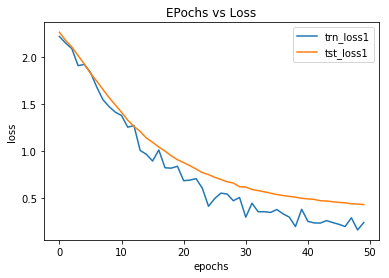

In [12]:
plt.plot(range(epoch),trn_loss1,label='trn_loss1')
plt.plot(range(epoch),tst_loss1,label='tst_loss1')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("EPochs vs Loss")
plt.legend()

In [13]:
# Accuracy of 1400 training data over each epoch in percentage
l_trn_accurate=[]
for i in trn_corr:
    l_trn_accurate.append(float(f'{i.item()/14:.2f}'))
print(l_trn_accurate)

[11.5, 30.07, 55.07, 64.64, 70.0, 71.71, 76.14, 78.14, 80.57, 82.57, 84.57, 85.79, 86.93, 87.43, 89.0, 90.0, 90.21, 91.64, 92.0, 92.29, 93.21, 93.21, 93.79, 94.14, 94.21, 94.43, 94.79, 95.07, 95.14, 95.43, 95.79, 95.86, 96.0, 96.36, 96.43, 96.64, 96.71, 96.71, 96.79, 96.93, 97.07, 97.0, 97.21, 97.36, 97.36, 97.43, 97.43, 97.57, 97.57, 97.57]


In [14]:
# Number of correct predictions out of 600 test data over each epoch
l_tst_accurate=[]
for i in tst_corr:
    l_tst_accurate.append(float(f'{i.item()/6:.2f}'))
print(l_tst_accurate)

[10.67, 44.5, 52.33, 61.17, 63.33, 69.67, 71.0, 73.5, 75.33, 77.0, 78.67, 79.17, 79.83, 82.0, 82.17, 82.5, 83.0, 84.17, 84.83, 84.83, 85.17, 85.17, 85.5, 85.83, 85.67, 85.83, 86.33, 86.0, 86.67, 87.0, 86.5, 87.17, 86.67, 87.5, 86.67, 87.33, 87.17, 87.33, 87.17, 87.0, 87.33, 87.17, 87.67, 87.67, 87.5, 87.17, 87.5, 87.17, 87.17, 87.17]


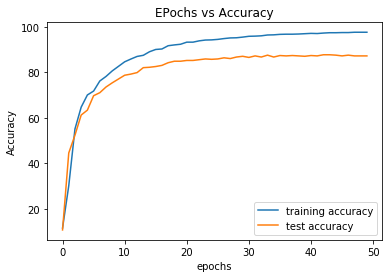

In [15]:
# Comparing the training accuracy and test accuracy
plt.plot(range(epoch),(l_trn_accurate),label='training accuracy')
plt.plot(range(epoch),(l_tst_accurate),label='test accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title("EPochs vs Accuracy")
plt.legend()

In [16]:
for i,j in enumerate(range(5)):
    model_1.eval()
    with torch.no_grad():
        new_pred = model_1(test_data[i][0].view(-1,784)).argmax()
        if new_pred != test_data[i][1]:
            print(f"{i+1}.) Predicted value: {new_pred.item()}    Actual label:{test_data[i][1]}     Incorrect prediction")
        else:
            print(f"{i+1}.) Predicted value: {new_pred.item()}    Actual label:{test_data[i][1]}     Correct prediction")

1.) Predicted value: 4    Actual label:4     Correct prediction
2.) Predicted value: 1    Actual label:1     Correct prediction
3.) Predicted value: 3    Actual label:3     Correct prediction
4.) Predicted value: 4    Actual label:4     Correct prediction
5.) Predicted value: 6    Actual label:6     Correct prediction
